# Donnelley Financial Solutions Data Challenge

### Import all these packages

In [1]:
# coding: utf-8
import PyPDF2
import plotly
import os
import csv
import matplotlib.pyplot as plt
import regex as re

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.text import Text
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk import pos_tag, ne_chunk
stop_words = stopwords.words('english')
stop_words.extend(['vanguard'])


import plotly.plotly as py
import plotly.graph_objs as go
from secrets import secrets as s
plotly.tools.set_credentials_file(username=s.username, api_key=s.api_key)

## Part1. Data Extraction

In [2]:
def collect_text_information(file):
    """
    Collects the data from the pdf file and returns the text information.
    
    Args:
        file - file reader reference object.
    
    Returns:
        text - A string containing all the text information in the document.
        text_content_pagewise - list of page-wise text information.
    """

    # creating a pdf reader object
    fileReader = PyPDF2.PdfFileReader(file)

    #convert to text document:
    num_pages = fileReader.numPages
    count = 0
    text = ""
    text_content_pagewise = []

    #The while loop will read each page
    while count < num_pages:
        pageObj = fileReader.getPage(count)
        count +=1
        temp_extracted_text = pageObj.extractText().replace('\n','')
        text += temp_extracted_text
        text_content_pagewise.append(temp_extracted_text)


    return text, text_content_pagewise


In [3]:
def get_input(file_name):
    """
    Getter method for input file_name
    
    Args:
        file_name - name of the file.
    
    Returns:
        file - file reader reference object.
    """
    try:
        file = open(file_name, 'rb')
    except:
        print(" ERROR: \n 1. Please make sure that PDF file name is correct. \n"
              "2. Please make sure your file is in the working directory. \n")
        
    return file
        

In [4]:
print("Enter the PDF name: eg: Vanguard.pdf")
file = get_input(input())
text, pagewise_textlist = collect_text_information(file)

Enter the PDF name: eg: Vanguard.pdf
Vanguard.pdf


## Part2. Data Processing

In [5]:
def data_preprocess(text):
    """
    Collects the data from the pdf file and returns the text information.
    
    Args:
        file - file reader reference object.
    
    Returns:
        text - A string containing all the text information in the document.
        text_content_pagewise - list of page-wise text information.
    """

    sentences = nltk.sent_tokenize(text)
    tokens = word_tokenize(text)


    keywords = [word.lower() for word in tokens if not word.lower() in stop_words and
                word not in punctuation and len(word) > 1 ]
    
    
    return keywords, sentences


In [6]:
keywords, sentences = data_preprocess(text)
text_list = Text(keywords)

#### What does the document look like?

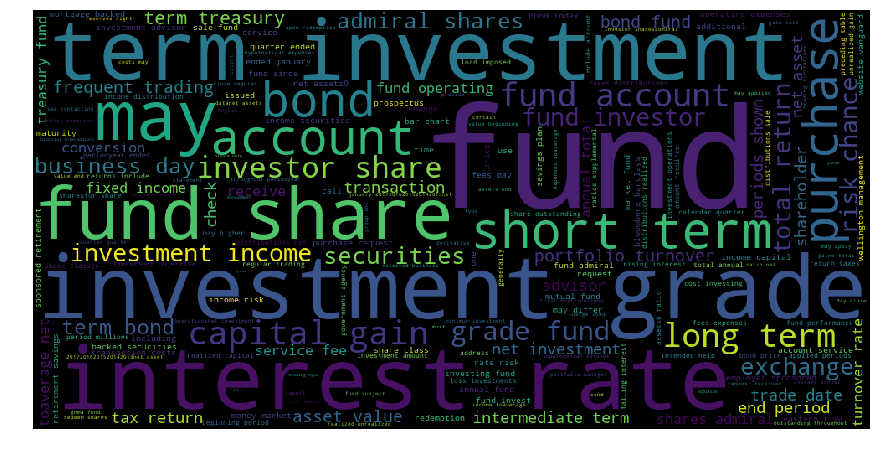

In [7]:
from wordcloud import WordCloud as wc
wordcloud1 = wc(width = 1000, height = 500).generate(' '.join(text_list))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud1)
plt.axis("off")
plt.show()

## Part3. Entity Extraction:

In [8]:
def write_output(fname, list_val):
    """
    Writes content of the list_val into fname and stores it in the working directory
    
    Args:
        fname - name of the file with .csv format.
        list_val - list of values.

    """
    with open(fname,'w') as output:
        writer = csv.writer(output, lineterminator='\n')
        for val in set(list_val):
            writer.writerow([val])

In [9]:
def extract_entity_names(t, entity_label): 
    """
    Extracts the entity from the chunked tree tags having entity_types
    
    Args:
        t - chunked sentences that has the pos tags.
        entity_label - label of the entity.
    
    Returns:
        entity_names - list of entities present.
    """
    entity_names = []

    if hasattr(t, 'label') and t.label:
        if t.label() == entity_label:
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child, entity_label))

    return entity_names

In [10]:
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]


In [11]:
entities = []

for each_tag_sentence in tagged_sentences: 
    chunked_sentence = ne_chunk(each_tag_sentence, binary=False)  
    entities.extend(extract_entity_names(chunked_sentence, 'ORGANIZATION')) 

In [12]:
write_output("entities.csv",entities)

# Part4: Model to find Data Point of Interest:

## Method1: Rule Based

#### Grammer Rule: NOUN followed by Number and then NOUN

In [13]:
chunk_gram = r"""Chunk: {<NN.>+<CD>+<NN.>+}"""

non_tagged_data_point_of_interest = []
chunk_parser = nltk.RegexpParser(chunk_gram)

for tagged in tagged_sentences:
    chunked = chunk_parser.parse(tagged)
    for subtree in chunked.subtrees():
        if subtree.label() == 'Chunk':
            non_tagged_data_point_of_interest.append(" ".join(w for w,t in tagged))

In [14]:
#solution: how many sentences we are interested in?
len(set(non_tagged_data_point_of_interest))

19

In [15]:
write_output("rule_based_data_points.csv",non_tagged_data_point_of_interest)

## Method2: Machine Learning approach

### Naive bayes

#### Labelling heuristics:
**1** - Interested

**0** - Not interested

In [16]:
train = [
    ('Management Fees', 1),
    ('Other Expenses', 1),
    ('Purchase Fee', 1),
    ('Sales Charge on Purchases', 1),
    ('invest in the Fund’s shares', 1),
    ('shares provide a return of 5% each year ', 1),
    ('Account Service Fee and for certain fund account balances', 1),
    ('Fund’s portfolio turnover rate was 24%', 1),
    ('distributions from realized capital gains', 1),
    ('fund sold and replaced securities valued at', 1),
    
    ('for fund account and service information', 0),
    ('7 days a week investor', 0),
    ('managed fund from april', 0),
    ('financial highlights ', 0),
    ('vanguard fund shares held directly with vanguard', 0),
    ('check to open a new account', 0),
    ('close of reqular trading on the NYSE', 0),
    ('section 529 college savings plans', 0),
    ('if you are registered user', 0),
    ('text telephone number 800-523-1188', 0)

]

In [17]:
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(train)

In [18]:
cl.classify("i will give you 5000 dollars")

0

In [19]:
cl.classify("Bond value is 5%")

1

In [20]:
ml_data_point_of_interest = []
for sentence in sentences:
    if cl.classify(sentence) == 1:
        ml_data_point_of_interest.append(sentence)

write_output('ml_data_point_interest.csv',ml_data_point_of_interest)

In [21]:
len(ml_data_point_of_interest)#captured more sentences of interest

428

#### Misclassification:

In [22]:
cl.classify("net assests are 2.63%")

0

# Part5: Visualization
#### To identify the pages that talk about the fees and expenses

In [23]:
input_word = ['expenses','fees']

In [24]:
num_pages = len(pagewise_textlist)
page_num_inorder_list = [i for i in range(num_pages)]#intialization

In [25]:
def get_dictionary_input_words_from_text(pagewise_textlist):
    """
    Gets the page-wise frequency distribution of words in the document
    
    Args:
        pagewise_textlist - list of page-wise text information.
    
    Returns:
        page_dict - List of dictionary with key-value as frequency distribution
    """

    page_dict = []
    lemmatized_list = []
    page_num = 0

    for each_word in input_word:
        lemmatized_word = wordnet_lemmatizer.lemmatize(each_word)
        lemmatized_list.append(lemmatized_word)

    for text_in_single_page in pagewise_textlist:
        tokens = word_tokenize(text_in_single_page)

        keywords_lemmatized = [wordnet_lemmatizer.lemmatize(word.lower()) for word in tokens
                    if not word.lower() in stop_words and word not in punctuation and len(word) > 1 ]

        fdist1 = nltk.FreqDist(keywords_lemmatized)
        page_dict.append(fdist1)

        page_num += 1
        
    return page_dict

In [26]:
page_dict = get_dictionary_input_words_from_text(pagewise_textlist)

In [27]:
ls_x1 = []
ls_x2 = []
total_val = []
for i in range(num_pages ):
    ls_x1.append(page_dict[i]['fee'])
    ls_x2.append(page_dict[i]['expense'])
    total_val.append(page_dict[i]['expense'] + page_dict[i]['fee'])

#### Plotly plot

In [28]:

# Add data
new_list = [x+1 for x in page_num_inorder_list]#starting page is 1

# Create and style traces
trace1 = go.Scatter(
    x = new_list,
    y = ls_x1,
    name = 'Fee'
)
trace2 = go.Scatter(
    x = new_list,
    y = ls_x2,
    name = 'Expense'
)

data = [trace1, trace2]

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Pagewise Tracking expenses and fees in the pdf',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Edit the layout
layout = dict(
              xaxis = dict(title = 'Page Number in the document'),
              yaxis = dict(title = 'Number of Occurences'),
              )
layout['annotations'] = annotations
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-line')

In [29]:
# Create and style traces
trace = go.Scatter(
    x = new_list,
    y = total_val,
    name = 'Expense+Fee'
)

data = [trace]

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Pagewise Tracking expenses+fees in the pdf',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Edit the layout
layout = dict(
              xaxis = dict(title = 'Page Number in the document'),
              yaxis = dict(title = 'Number of Occurences'),
              )
layout['annotations'] = annotations
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-line')